In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Split the images and masks into train and validation sets
from sklearn.model_selection import train_test_split

In [ ]:
# Set hyperparameters
input_shape = (128, 128, 3)
batch_size = 16
learning_rate = 0.001
num_epochs = 5
# Set the desired image size and batch size
target_size = (128, 128)

In [ ]:
# Set the path to the train and test directories
image_train_dir = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/image/train/G2/'
image_test_dir ='/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/image/val/G2/'

# Set the path to the train and test directories
mask_train_dir = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/mask/train/G2/'
mask_test_dir = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/mask/val/G2/'

# Set the desired image size and batch size
target_size = (128, 128)
batch_size = 16

# Create data generators for images and masks separately
image_data_gen = ImageDataGenerator(rescale=1./255)
mask_data_gen = ImageDataGenerator(rescale=1./255)

# Create the train generator for images
train_image_generator = image_data_gen.flow_from_directory(
    image_train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Create the train generator for masks
train_mask_generator = mask_data_gen.flow_from_directory(
    mask_train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Create the test generator for images
test_image_generator = image_data_gen.flow_from_directory(
    image_test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Create the test generator for masks
test_mask_generator = mask_data_gen.flow_from_directory(
    mask_test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Combine the image and mask generators
train_generator = zip(train_image_generator, train_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

Found 2812 images belonging to 1 classes.
Found 2812 images belonging to 1 classes.
Found 704 images belonging to 1 classes.
Found 704 images belonging to 1 classes.


In [ ]:
def unet(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    output = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
def compute_iou(gt_mask, pred_mask):
    intersection = tf.logical_and(gt_mask, pred_mask)
    union = tf.logical_or(gt_mask, pred_mask)
    iou = tf.reduce_sum(tf.cast(intersection, dtype=tf.float32)) / tf.reduce_sum(tf.cast(union, dtype=tf.float32))
    return iou

def compute_mean_iou(gt_masks, pred_masks):
    total_iou = tf.constant(0.0, dtype=tf.float32)
    num_samples = tf.shape(gt_masks)[0]

    for i in tf.range(num_samples):
        gt_mask = gt_masks[i]
        pred_mask = pred_masks[i]
        iou = compute_iou(gt_mask, pred_mask)
        total_iou += iou

    mean_iou = total_iou / tf.cast(num_samples, dtype=tf.float32)
    return mean_iou

class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        gt_masks = tf.cast(y_true, dtype=tf.bool)
        pred_masks = tf.cast(tf.round(y_pred), dtype=tf.bool)
        iou = compute_mean_iou(gt_masks, pred_masks)
        self.total_iou.assign_add(iou)
        self.num_samples.assign_add(1.0)

    def result(self):
        return self.total_iou / self.num_samples

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.num_samples.assign(0.0)

# Example usage
# Assuming gt_masks and pred_masks are tensors of binary masks

# Create an instance of the MeanIoU metric
mean_iou_metric = MeanIoU()

In [ ]:
# Define the U-Net model
model = unet(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy',mean_iou_metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# Set the number of steps per epoch and validation steps
train_steps = len(train_image_generator)
val_steps = len(test_image_generator)

In [ ]:
model.fit(
    train_generator,
    epochs=train_steps,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=val_steps,
)

Epoch 1/176
100/100 [==============================] - 658s 6s/step - loss: 0.5008 - accuracy: 0.7060 - mean_iou: 0.0666 - val_loss: 0.4730 - val_accuracy: 0.7778 - val_mean_iou: 0.5322
Epoch 2/176
100/100 [==============================] - 173s 2s/step - loss: 0.4309 - accuracy: 0.8036 - mean_iou: 0.5496 - val_loss: 0.4434 - val_accuracy: 0.7856 - val_mean_iou: 0.5362
Epoch 3/176
100/100 [==============================] - 22s 225ms/step - loss: 0.4199 - accuracy: 0.8107 - mean_iou: 0.5733 - val_loss: 0.4519 - val_accuracy: 0.7930 - val_mean_iou: 0.5365
Epoch 4/176
100/100 [==============================] - 23s 226ms/step - loss: 0.4196 - accuracy: 0.8039 - mean_iou: 0.5650 - val_loss: 0.4242 - val_accuracy: 0.7883 - val_mean_iou: 0.5432
Epoch 5/176
100/100 [==============================] - 26s 264ms/step - loss: 0.3991 - accuracy: 0.8250 - mean_iou: 0.6077 - val_loss: 0.4304 - val_accuracy: 0.7879 - val_mean_iou: 0.5652
Epoch 6/176
100/100 [==============================] - 26s 263ms

In [ ]:
# Save the model to an HDF5 file
model_filename ="/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/model/unet.h5"
model.save(model_filename)

1/1 [==============================] - 9s 9s/step


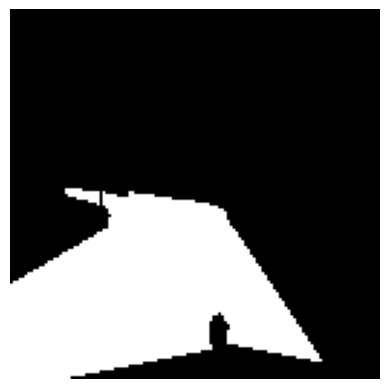

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/model/unet.h5", custom_objects={'MeanIoU': MeanIoU})

# Perform inference on a single image
def infer_image(image_path, model,target_size=(128, 128)):
    image = Image.open(image_path)
    image = image.resize(target_size)  # Resize the image to the target size
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    mask_array = model.predict(image_array)
    mask_array = (mask_array[0, :, :, 0] > 0.5).astype(np.uint8) * 255
    return mask_array

# Define the path to the image you want to infer on
test_image_path = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/image/val/G2/Rainy_to_Cloudy/Rainy_to_Cloudy_image_0.png'
gt_mask_path = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/mask/val/G2/Rainy_to_Cloudy/Rainy_to_Cloudy_image_0.png'

# Perform inference on the test image
predicted_mask = infer_image(test_image_path, saved_model)

# Display the masked image
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 223ms/step


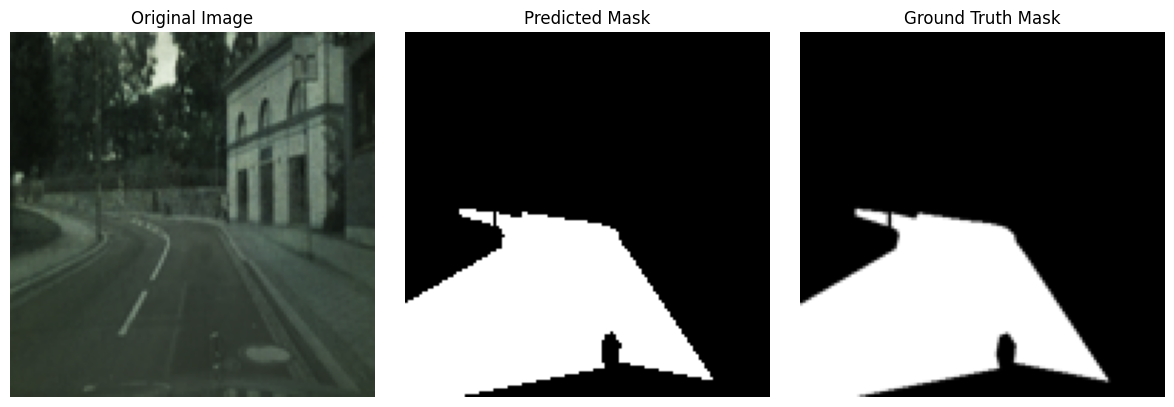

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/model/unet.h5", custom_objects={'MeanIoU': MeanIoU})

# Perform inference on a single image
def infer_image(image_path, model, target_size=(128, 128)):
    image = Image.open(image_path)
    image = image.resize(target_size)  # Resize the image to the target size
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    mask_array = model.predict(image_array)
    mask_array = (mask_array[0, :, :, 0] > 0.5).astype(np.uint8) * 255
    return image_array[0], mask_array

# Define the path to the image you want to infer on
test_image_path = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/image/val/G2/Rainy_to_Cloudy/Rainy_to_Cloudy_image_0.png'
gt_mask_path = '/content/drive/MyDrive/Colab Notebooks/segmentation/dataset/data/dataset/mask/val/G2/Rainy_to_Cloudy/Rainy_to_Cloudy_mask_0.png'

# Perform inference on the test image
original_image, predicted_mask = infer_image(test_image_path, saved_model)

# Load and resize the ground truth mask
gt_mask = Image.open(gt_mask_path)
gt_mask = gt_mask.resize(predicted_mask.shape[:2])  # Resize to the same shape as predicted_mask
gt_mask_array = img_to_array(gt_mask) / 255.0

# Display the images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gt_mask_array, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
